# Seismic Transformer-Base

*Author: Jason Jiang (Xunfun Lee)*

*Date: 2023.11.27*

**Notes:** 
1. This model is used to demonstrast Transformer architecture is suitable for region seismic assessment and compare the performance with R-49 (ResNet) which created by @Jie Zheng. The parameter of SeT-Base-1 remain the same as R-49 as more as possible. The ground motions (GMs) data directly comes from @Jie Zheng's job. Many thanks for your job :)
2. The architecture of SeT-Base-1 refer to ViT-Base (Vision Transformer) which has 86M parameter in total.
3. You can run this notebook in Mac, Windows or Linux (Google Colab). All directory is relative, so make sure you download the whole folder included the "Data" folder.
4. This notebook aim to find a way to build our transformer architecture. Before this notebook I haven't build any transformer architecture based deep learning framework by myself, so you can think this notebook for a test purpose and a tutorial of transformer for the learner.

## Parameter

### Data

| **Object** | **Number** | **Memo** |  
| ----- | ----- | ----- |
| **Length of Ground Motion** | 3,000  | 60s - 50Hz |
| **Length of Train dataset** | 60,940 | K-NET |
| **Length of Validation dataset** | 51,725 | K-NET |
| **Length of Test dataset** | 1,715 | PEER |
| **Mode of GMs expendtion** | padding | padding 0 into GMs which don't have 60s |
| **Size of patch** | 250 | 250 is best for any time of time-series data rather than 300 |
| **Num of patch** | 12 | 3,000 / 250 = 12 |

### Model Parameter

| **Parameter** | **Content** | **Memo** |  
| ----- | ----- | ----- |
| **Embedding Size** | 768  | Can be divided by 8 and 12, the same as ViT-Base |
| **Layer** | 12 | Number of encoder, the same as ViT-Base |
| **Hidden Size** | 768 | Can be divided by 8 and 12, the same as ViT-Base, equal to embeding size |
| **Head** | 12 | Number of heads in multi-head attention block, the same as ViT-Base |
| **Optimizer** | adam | Adaptive Moment Estimation, can switch to adamW or Stochastic Gradient Descent (`SGD`) |
| **Loss function** | Cross-Entropy Loss | Suitable for multiple classification problem, the same as ViT-Base |
| **Activate function** | GuLU | The same as ViT-Base, can try `ReLU` |

### Train Parameter

| **Parameter** | **Number** | **Memo** |  
| ----- | ----- | ----- |
| **Batch Size** | 64 (default, for test) | *Optional*, specify in the model name |
| **Epoch** | 10 (default, for test) | *Optional*, specify in the model name |
| **Learning Rate** | 0.003  | *Optional*, 0.003 is the same as ViT-Base |


## -1. Dependency and Device

System: Windows 10 Pro

| **Device Name** | **Model ID** | **Memo** |  
| ----- | ----- | ----- |
| **CPU** | i7-10700K | 3.79 GHz |
| **RAM** | 64 GB | 16 DDR4*4 |
| **GPU** | RTX-3090ti  | 24GB VRAM |

> **Note:** For RTX-390ti(24GB), BATCH_SIZE = 64 is using 23.4/24 GB. You can simply change the BATCH_SIZE to fit your VRAM

In [1]:
import torch
from torch import nn
import numpy as np
import h5py                 # due with the matlab file, learned from @Jie Zheng's python scripts
from torchinfo import summary

In [2]:
# device
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available")
    print("CUDA device numbers: ", torch.cuda.device_count())
    !nvidia-smi
elif torch.backends.mps.is_available():
    device = "mps"
    print("MPS is available")
else:
    device = "cpu"
    print("No GPU found, using CPU")

device

CUDA is available
CUDA device numbers:  1
Tue Dec  5 15:04:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   49C    P8    29W / 480W |   2640MiB / 24564MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                              

'cuda'

## 0. Hyper-parameters

In [3]:
# Data parameter
GM_LENGTH = 3000
PATCH_SIZE = 250

# Transformer parameter
HIDDEN_SIZE = 384
NUM_HEAD = 6
NUM_LAYER = 6

# Training parameter
BATCH_SIZE = 64
NUM_EPOCH = 5
LEARNING_RATE = 0.001

## 1. Data Preparation

### Data path

This data directly comes from raw datasets in matlab format.

> **Note**: The data in balBySameInd.mat is equal to bal.mat

In [4]:
import os

traindata_path = os.path.join("Data", "50Hz_60s", "train", "cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat")      # length = 60940
valdata_path = os.path.join("Data", "50Hz_60s", "validation", "cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat")      # length = 51725
testdata_path = os.path.join("Data", "50Hz_60s", "test", "cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat")      # length = 1715

# only for windows, can't use in macos
# traindata_path = r'Data\50Hz_60s\train\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat'      # length = 60940
# valdata_path = r'Data\50Hz_60s\validation\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat'   # length = 51725
# testdata_path = r'Data\50Hz_60s\test\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat'        # length = 1715

traindata_path, valdata_path, testdata_path

('Data\\50Hz_60s\\train\\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat',
 'Data\\50Hz_60s\\validation\\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat',
 'Data\\50Hz_60s\\test\\cnn_[0.1-dif-20_57spp]_center-50Hz-60s_Mode0_x10_balBySameInd.mat')

### Data process

We are going to use "h5py" library to extract the data and using "numpy" to transpose, add time-series data and label together.

*Here I find a mistake in @Jie Zheng's job, the length of training data: length of validation data usually is 8:2 or 7:3, here it is 6:5. And he even shift the training data and the validation data to implement "正训" and "反训" in order to get two different model, which doesn't make any sense. In machine learning problems, shifting the training data and validation data during every epoches is more reasonable. However, in order to compare to R-49, Set-Base-1 maintain his option.*

> **Oppotunities**: If there is time you can train the ResNet with @Jie Zheng's code to make 8:2 training and validation data, and compare it to the SeT model with the same option, then it is more reasonable for a machine learning job. However, professors in civil engineering won't notice this rule :p you know what I am saying.

In [5]:
# train data: will influence the weights of the model
train_gm_recs = np.transpose(h5py.File(traindata_path, 'r')['gms'])
train_labels = np.transpose(h5py.File(traindata_path, 'r')['labels'])

# validation data: just calculate the lost function, won't influence the backpropogation process
val_gm_recs = np.transpose(h5py.File(valdata_path, 'r')['gms'])
val_labels = np.transpose(h5py.File(valdata_path, 'r')['labels'])

# test data: using to test the model after the model is trained completely
test_gm_recs = np.transpose(h5py.File(testdata_path, 'r')['gms'])
test_labels = np.transpose(h5py.File(testdata_path, 'r')['labels'])

print(f"Length of train dataset({len(train_gm_recs)}) --> label({len(train_labels)})")
print(f"Length of validation dataset({len(val_gm_recs)}) --> label({len(val_labels)})")
print(f"Length of test dataset({len(test_gm_recs)}) --> label({len(test_labels)})")
print(f"Shape of train dataset({train_gm_recs.shape}) = {len(train_gm_recs)} GMs * 3000 points/GM --> label({train_labels.shape})")
print(f"Shape of validation dataset({val_gm_recs.shape}) = {len(val_gm_recs)} GMs * 3000 points/GM --> label({val_labels.shape})")
print(f"Shape of test dataset({test_gm_recs.shape}) = {len(test_gm_recs)} GMs * 3000 points/GM --> label({test_labels.shape})")

Length of train dataset(60940) --> label(60940)
Length of validation dataset(51725) --> label(51725)
Length of test dataset(1715) --> label(1715)
Shape of train dataset((60940, 3000)) = 60940 GMs * 3000 points/GM --> label((60940, 1))
Shape of validation dataset((51725, 3000)) = 51725 GMs * 3000 points/GM --> label((51725, 1))
Shape of test dataset((1715, 3000)) = 1715 GMs * 3000 points/GM --> label((1715, 1))


### Visualize data

Plot a random ground motion time-series data to check if the data is normal:

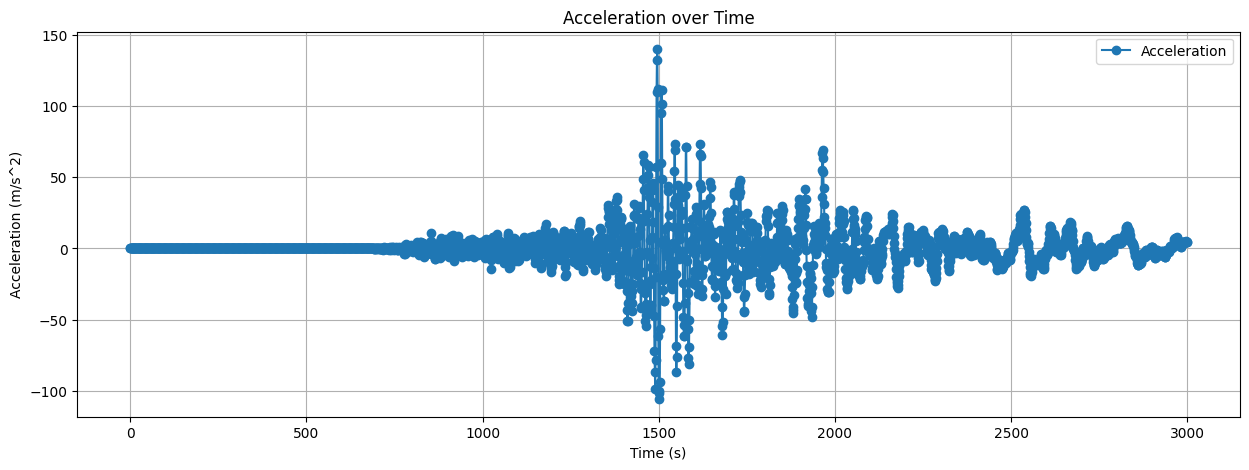

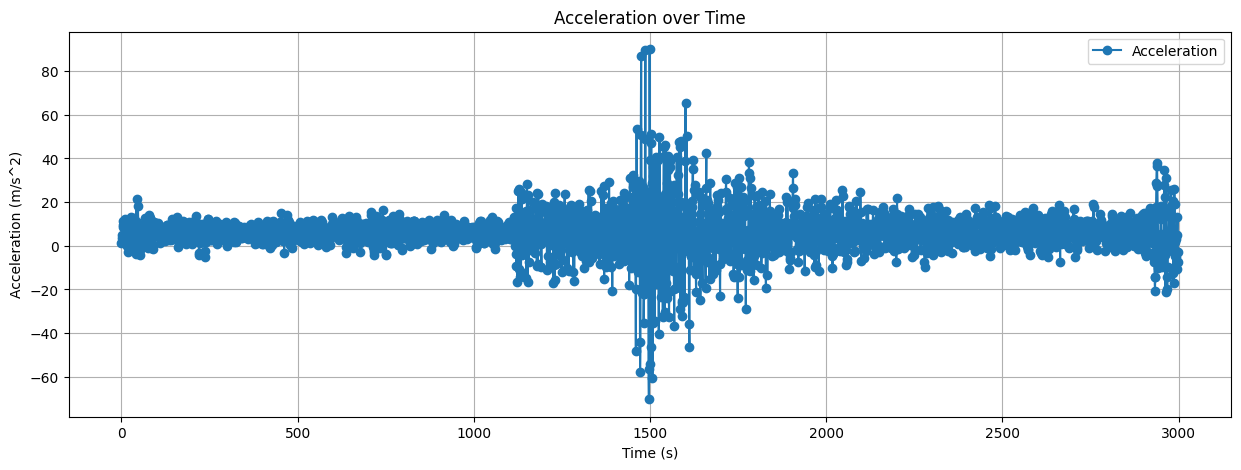

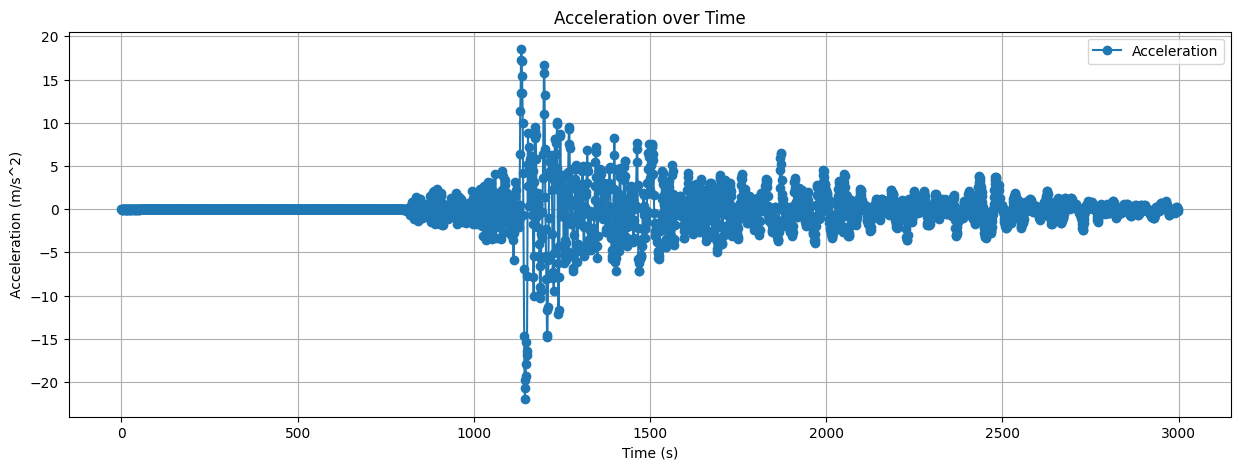

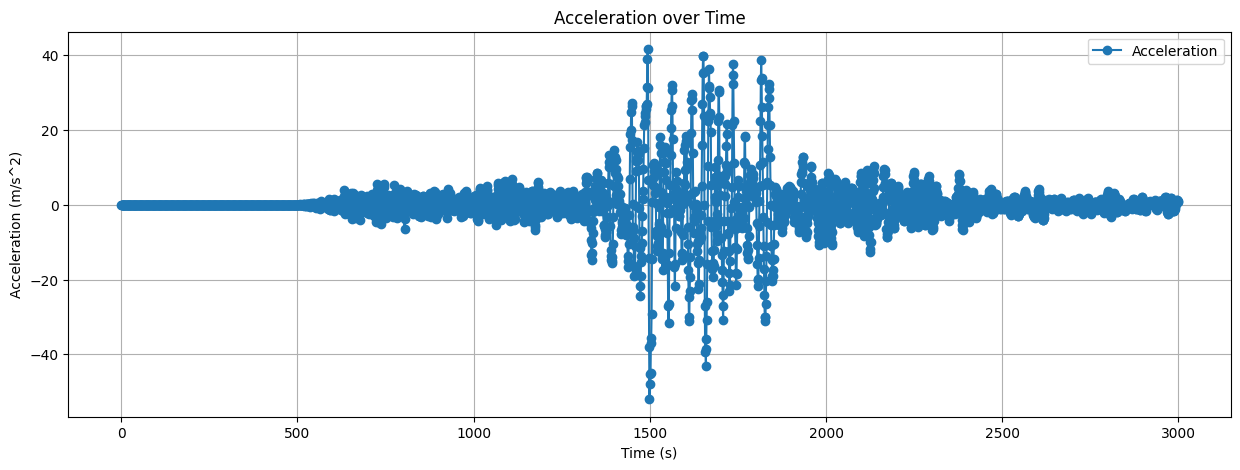

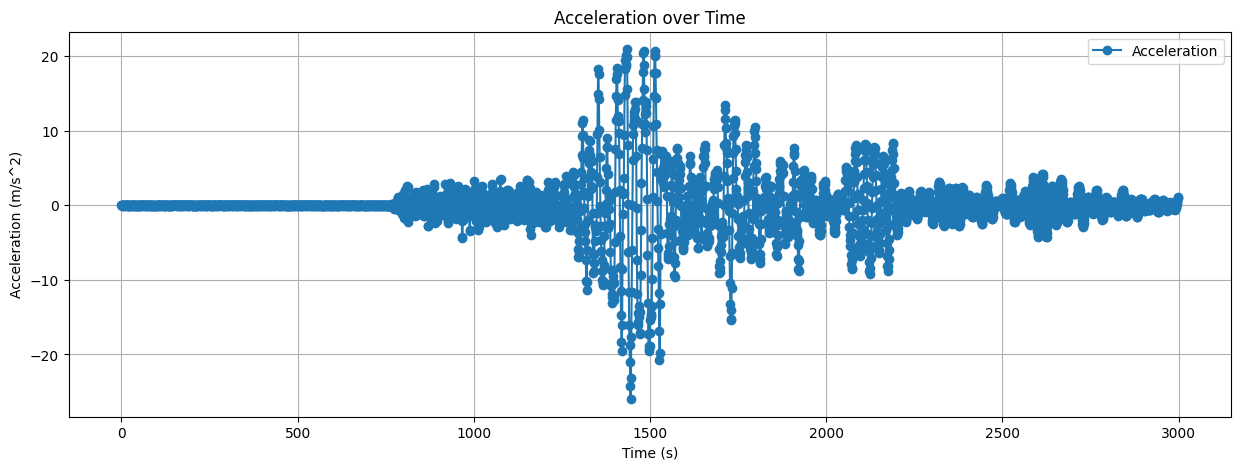

In [8]:
import matplotlib.pyplot as plt
import random

numOfSubPlot = 5
dataOfSubPlot = train_gm_recs
# dataOfSubPlot = val_gm_recs
# dataOfSubPlot = test_gm_recs

# Generate 3000 points for 60s
times = []
for i in range(0,3000):
    times.append(i)
    i = i + 0.02
    
def createsubplot():
    numOfGM = random.randint(1, len(dataOfSubPlot))
    plt.figure(figsize=(15, 5))
    plt.plot(times, dataOfSubPlot[numOfGM], marker='o', linestyle='-')
    plt.title('Acceleration over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

for i in range(0, numOfSubPlot):
    createsubplot()

## 2. Turn Data into tensor, create dataLoaders, create embedding

### 2.1 Numpy array to Tensor

In [123]:
# data
train_data = torch.from_numpy(train_gm_recs)
validation_data = torch.from_numpy(val_gm_recs)
test_data = torch.from_numpy(test_gm_recs)
# Add a extra dimension to time-series data
train_data = train_data.unsqueeze(2)                        # [60940, 3000] --> [60940, 3000, 1]
validation_data = validation_data.unsqueeze(2)  
test_data = test_data.unsqueeze(2)  

# label
train_label = torch.from_numpy(train_labels)
validation_label = torch.from_numpy(val_labels)
test_label = torch.from_numpy(test_labels) 
# Kill an extra dimensioni to label, and don't forget to add .long() for the loss function
train_label = torch.squeeze(train_label).long()             # [60940, 1] --> [60940], loss function need 0D input, not 1D, and it need int, not double type
validation_label = torch.squeeze(validation_label).long()
test_label = torch.squeeze(test_label).long()

# test the accuracy
# validation_label = torch.randint(low=0, high=5, size=(51725,))

train_data.shape, validation_data.shape, test_data.shape

(torch.Size([60940, 3000, 1]),
 torch.Size([51725, 3000, 1]),
 torch.Size([1715, 3000, 1]))

#### *Check the original data is correct*

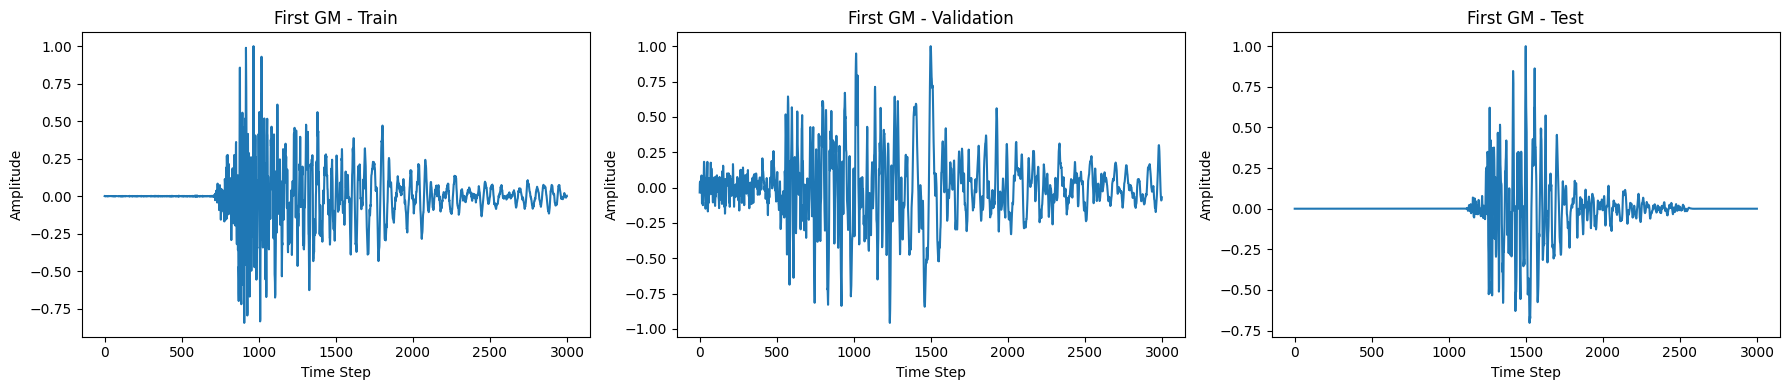

In [125]:
first_GM_train = train_data[0,:,0]
first_GM_validation = train_data[0,:,0]
first_GM_test = train_data[0,:,0]

plt.figure(figsize=(18, 4))
# first GM of train
plt.subplot(1, 3, 1)
plt.plot(first_GM_train)
plt.title('First GM - Train')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
# first GM of validation
plt.subplot(1, 3, 2)
plt.plot(first_GM_validation)
plt.title('First GM - Validation')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
# first GM of test
plt.subplot(1, 3, 3)
plt.plot(first_GM_test)
plt.title('First GM - Test')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
# plot the image
plt.tight_layout()
plt.show()

In [126]:
# pay every attention to this, because lower the dimension will change the label number maybe.
train_label, validation_label, test_label, train_label.shape, validation_label.shape, test_label.shape

(tensor([0, 0, 0,  ..., 4, 4, 4]),
 tensor([0, 0, 0,  ..., 4, 4, 4]),
 tensor([0, 0, 0,  ..., 4, 4, 4]),
 torch.Size([60940]),
 torch.Size([51725]),
 torch.Size([1715]))

### 2.2 Create dataLoaders

Using `DataLoader` from `torch.utils.data` library to create a dataloader

In [127]:
from torch.utils.data import DataLoader, TensorDataset

# create data loader function
def CreateDataLoader(input_data, labels, batch_size):
    dataset = TensorDataset(input_data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_dataloader = CreateDataLoader(train_data, train_label, BATCH_SIZE)
validation_dataloader = CreateDataLoader(validation_data, validation_label, BATCH_SIZE)
test_dataloader = CreateDataLoader(test_data, test_label, BATCH_SIZE)

class_name = ["0", "1", "2", "3", "4"]

train_dataloader, validation_dataloader, test_dataloader, class_name

(<torch.utils.data.dataloader.DataLoader at 0x25b9553f700>,
 ['0', '1', '2', '3', '4'])

### 2.3 Visualize the data in dataloader

In [128]:
# Get a batch of data
ground_motion_batch, label_batch = next(iter(train_dataloader))

# Get a single time series curve and label
ground_motion, label = ground_motion_batch[0], label_batch[0].item()

ground_motion, label, ground_motion.shape # label.shape

(tensor([[ 0.0000],
         [-0.0016],
         [-0.0008],
         ...,
         [ 0.0536],
         [-0.0463],
         [-0.0448]]),
 0,
 torch.Size([3000, 1]))

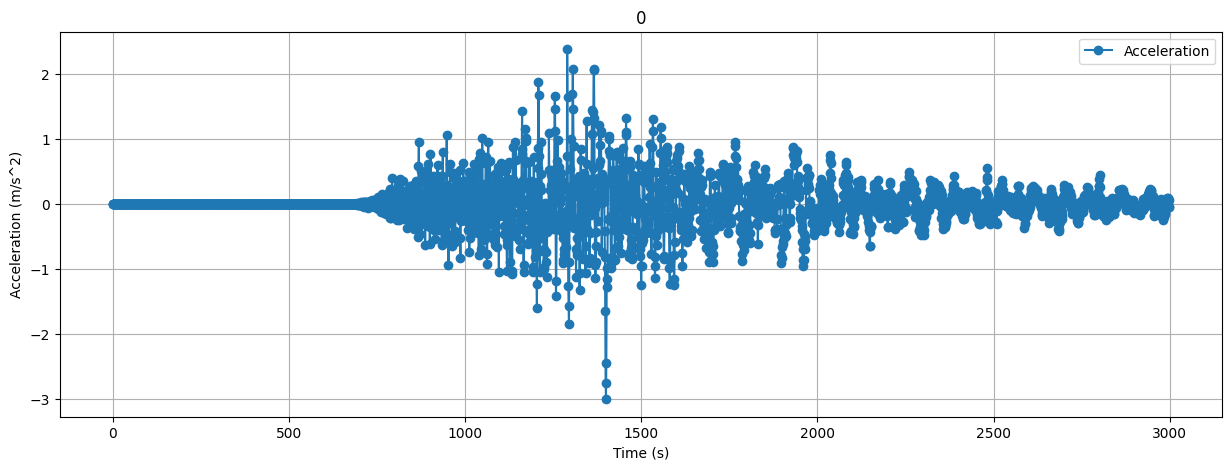

In [129]:
plt.figure(figsize=(15, 5))
plt.plot(times, ground_motion, marker='o', linestyle='-')
plt.title(label)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.legend(['Acceleration'])
plt.show()

## 3. Split data into patches

### 3.1 Calculating patch embedding input and output shape by hand

As the transformer usually learn from piece of the data, we need to split them, the patch size is *optional*, need to be test before we confirm for the final SeT-Huge model.

In [130]:
# Create example values

number_of_patch = int(GM_LENGTH / PATCH_SIZE)
print(f"Number of patches (N = {number_of_patch}), with time-series-length (L = {GM_LENGTH}) and patch size (Size = {PATCH_SIZE})")

Number of patches (N = 12), with time-series-length (L = 3000) and patch size (Size = 250)


As the time-series data is already 1D (while image is 2D), so:

* input shape: 3000 x 1 ( ${Length \times 1}$ )
* output shape: 12 x 250 ( ${N \times P}$ )

> **Note:** Now we are just consider about 1D of the data, X or Y or Z direction of the ground motions, in the future, SeismicGPT need to dual with multi-dimension of the GMs and the data process here is different. However, since X, Y, Z is 1D, we can simply splice them into a long 1D array even we need to do FFT (fast fourier transform) and add the properties of the structure. But for now we don't need to worry about these thing, just complete our first job :)

In [131]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (GM_LENGTH, 1)

# Output shape
embedding_layer_output_shape = (number_of_patch, PATCH_SIZE)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (3000, 1)
Output shape (single 2D image flattened into patches): (12, 250)


### 3.2 Visualize the patch job (won't get you a tensor to use, just visualize the whole process)

Visualize a time-series again:

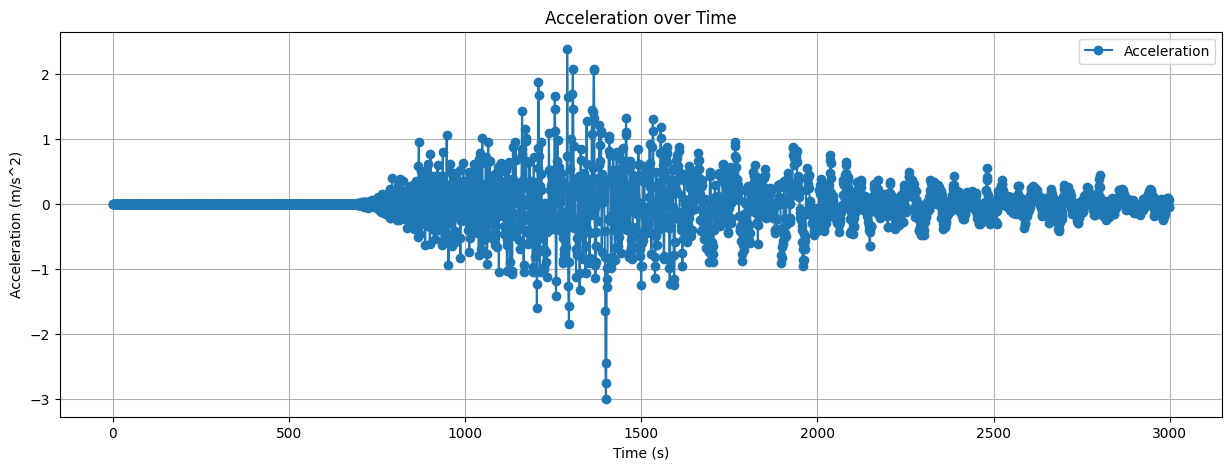

In [132]:
from PythonScripts.helper_functions import set_seeds

# create a random time-series curve
numOfGM = random.randint(1, len(dataOfSubPlot))
plt.figure(figsize=(15, 5))
plt.plot(times, ground_motion, marker='o', linestyle='-')
plt.title('Acceleration over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.legend(['Acceleration'])
plt.show()

Split it into 12 pieces:

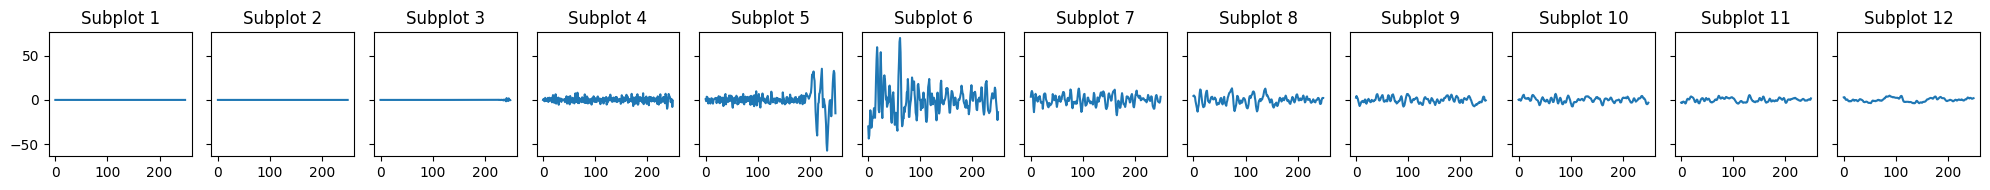

In [133]:
# number of sub plots = Length / patch_size
num_subplots = GM_LENGTH / PATCH_SIZE

# each points of the subplot
points_per_subplot = int(GM_LENGTH // num_subplots)

# create the figure and subplot
fig, axes = plt.subplots(nrows=1, ncols=int(num_subplots), figsize=(20, 2), sharex=True, sharey=True)

# create every subplot
for i in range(int(num_subplots)):
    start_index = i * points_per_subplot
    end_index = (i + 1) * points_per_subplot if i < num_subplots - 1 else GM_LENGTH
    axes[i].plot(dataOfSubPlot[numOfGM][start_index:end_index])
    axes[i].set_title(f"Subplot {i + 1}")

# gap between subplot
plt.tight_layout()

# show the image
plt.show()

Turn the training data into tensor from numpy array first:

### 3.3 Creating patch embedding layer

Patch the 3000 length into 250

* **Input size** = [3000, 1]
* **Output size** = [12, 250]

In [134]:
class PatchEmbedding(nn.Module):
    def __init__(self, num_patches, patch_size):
        """
        Args:
          num_patches: 分成的块数
          patch_size: 单个块的大小
        """
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.hidden_size = patch_size

    def forward(self, x):
        """
        Args:
          x: 输入张量，形状为 [batch_size, sequence_length, channels]
             其中 sequence_length 应该等于 num_patches * patch_size
        Returns:
          分块后的张量，形状为 [batch_size, num_patches, patch_size]
        """
        # 验证输入数据的长度是否符合预期
        assert x.shape[1] == self.num_patches * self.hidden_size, \
            f'Input sequence length should be {self.num_patches * self.hidden_size}'

        # 把输入张量从 [batch_size, sequence_length, channels] 重塑为
        # [batch_size, num_patches, hidden_size]
        x = x.view(-1, self.num_patches, self.hidden_size)
        return x

In [135]:
summary(PatchEmbedding(number_of_patch, PATCH_SIZE),
        input_size=(BATCH_SIZE, GM_LENGTH, 1),        # Batch size, Length of the ground motion, patch size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [64, 3000, 1]        [64, 12, 250]        --                   --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.77
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.77

Create a instance to patch a ground motion data:

In [136]:
patchify = PatchEmbedding(number_of_patch, PATCH_SIZE)
print(f"Input groud motion shape: {ground_motion.unsqueeze(-1).unsqueeze(0).shape}")
patch_ground_motion = patchify(ground_motion.unsqueeze(-1).unsqueeze(0))
print(f"Output patch embedding shape: {patch_ground_motion.shape}")

Input groud motion shape: torch.Size([1, 3000, 1, 1])
Output patch embedding shape: torch.Size([1, 12, 250])


### 3.4 Create projection Layer

Increase dimension from 250 to 768 for embedding.

* **Input size** = [12, 250]
* **Output size** = [12, 768]

In [137]:
class ProjectionModule(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ProjectionModule, self).__init__()
        self.up_project = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        return self.up_project(x)

In [138]:
summary(ProjectionModule(PATCH_SIZE, HIDDEN_SIZE),
        input_size=(BATCH_SIZE, number_of_patch, PATCH_SIZE),        # Batch size, number of patch, patch size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ProjectionModule (ProjectionModule)      [64, 12, 250]        [64, 12, 384]        --                   True
├─Linear (up_project)                    [64, 12, 250]        [64, 12, 384]        96,384               True
Total params: 96,384
Trainable params: 96,384
Non-trainable params: 0
Total mult-adds (M): 6.17
Input size (MB): 0.77
Forward/backward pass size (MB): 2.36
Params size (MB): 0.39
Estimated Total Size (MB): 3.51

Create a instance to embed a ground motion (after patching) data:

In [139]:
projection = ProjectionModule(PATCH_SIZE, HIDDEN_SIZE)
print(f"Input groud motion shape: {patch_ground_motion.shape}")
patch_embedded_ground_motion = projection(patch_ground_motion)
print(f"Output patch embedding shape: {patch_embedded_ground_motion.shape}")

Input groud motion shape: torch.Size([1, 12, 250])
Output patch embedding shape: torch.Size([1, 12, 384])


### 3.5 Create class token embedding (using it to do classification job)

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). 

> **Note:** [BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

First check the patch_embed_ground_motion

In [140]:
# View the patch embedding and patch embedding shape
print(patch_embedded_ground_motion)
print(f"Patch embedding shape: {patch_embedded_ground_motion.shape} -> [batch_size, number_of_patches, embedding_dimension]")

# check the first and the last number of the shape: batch size and hidden size
patch_embedded_ground_motion.shape, patch_embedded_ground_motion.shape[0], patch_embedded_ground_motion.shape[-1]

tensor([[[-0.0365,  0.0123,  0.0463,  ..., -0.0058, -0.0106,  0.0269],
         [-0.0382,  0.0116,  0.0456,  ..., -0.0054, -0.0111,  0.0267],
         [-0.0516,  0.0064,  0.0499,  ..., -0.0042, -0.0102,  0.0275],
         ...,
         [-0.0198,  0.0231,  0.1364,  ..., -0.0295,  0.0052,  0.0523],
         [-0.0399, -0.0512, -0.0021,  ...,  0.0224, -0.0302,  0.0937],
         [-0.1555, -0.1427, -0.1638,  ..., -0.0665, -0.0527, -0.0065]]],
       grad_fn=<ViewBackward0>)
Patch embedding shape: torch.Size([1, 12, 384]) -> [batch_size, number_of_patches, embedding_dimension]


(torch.Size([1, 12, 384]), 1, 384)

Then we need to add CLS token in front of the embedding, in pseudocode:

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding (Learnable class token)
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

In [141]:
batch_size = patch_embedded_ground_motion.shape[0]                 # batch size = 1
embedding_dimension = patch_embedded_ground_motion.shape[-1]       # hidden size = 768

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[ 1.8399, -0.9042, -0.5942,  3.0369, -1.2880, -0.9710, -1.2326,
           0.2194, -0.3870, -1.5816]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 384]) -> [batch_size, number_of_tokens, embedding_dimension]


Add one dimension as the size of the embedding size (also hidden size) using `torch.cat()`:
* **Input**: [12, 768]
* **Output**: [13, 768]

In [142]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_ground_motion_with_class_embedding = torch.cat((class_token, patch_embedded_ground_motion), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_ground_motion_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_ground_motion_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.8399, -0.9042, -0.5942,  ...,  0.3505, -0.7426,  1.2136],
         [-0.0365,  0.0123,  0.0463,  ..., -0.0058, -0.0106,  0.0269],
         [-0.0382,  0.0116,  0.0456,  ..., -0.0054, -0.0111,  0.0267],
         ...,
         [-0.0198,  0.0231,  0.1364,  ..., -0.0295,  0.0052,  0.0523],
         [-0.0399, -0.0512, -0.0021,  ...,  0.0224, -0.0302,  0.0937],
         [-0.1555, -0.1427, -0.1638,  ..., -0.0665, -0.0527, -0.0065]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 13, 384]) -> [batch_size, number_of_patches, embedding_dimension]


### 3.6 Creating the position embedding

Retain positional information: the architecture can know the "order" the patches come in.

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings** here.

Position embedding just add to whole embedding (including the class token):
* **Input**: [13, 768] (after adding class embedding)
* **Output**: [13, 768] (after adding class embedding)

In [143]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_ground_motion_with_class_embedding, patch_embedded_ground_motion_with_class_embedding.shape

(tensor([[[ 1.8399, -0.9042, -0.5942,  ...,  0.3505, -0.7426,  1.2136],
          [-0.0365,  0.0123,  0.0463,  ..., -0.0058, -0.0106,  0.0269],
          [-0.0382,  0.0116,  0.0456,  ..., -0.0054, -0.0111,  0.0267],
          ...,
          [-0.0198,  0.0231,  0.1364,  ..., -0.0295,  0.0052,  0.0523],
          [-0.0399, -0.0512, -0.0021,  ...,  0.0224, -0.0302,  0.0937],
          [-0.1555, -0.1427, -0.1638,  ..., -0.0665, -0.0527, -0.0065]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 13, 384]))

In [144]:
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patch+1, 
                                             HIDDEN_SIZE),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches+1, embedding_dimension]")

tensor([[[ 0.8333, -1.8721, -0.6526, -0.9521, -0.0741, -0.8041,  0.6592,
          -1.2535, -1.2699, -0.3385],
         [-0.4282,  0.1206,  0.0281, -0.2868,  1.6633,  0.6371, -0.0701,
          -0.2110, -0.4938,  0.2359],
         [ 1.1249, -0.1408,  0.7698,  0.4204,  1.5285, -2.6472, -0.0596,
           0.2254, -1.6432,  0.5062],
         [-1.1215, -1.2738,  1.4288, -0.3161,  0.5351, -0.5625,  0.2178,
          -1.0795,  1.8365,  1.2748],
         [ 1.3590, -1.1929,  0.4218,  0.3378, -0.1071, -0.9128,  0.5900,
          -0.1803,  0.5938,  1.4439],
         [ 0.0286,  1.2402, -0.2878, -0.4913,  1.2569, -0.5431, -1.3499,
          -1.1232,  0.7901,  0.3107],
         [ 1.1137, -0.3316, -0.8534, -1.1303,  1.4359, -0.5158, -1.7843,
          -0.2910, -0.7413, -0.9943],
         [-0.9313,  0.3957, -1.2059,  0.0089, -0.6643,  0.7217,  0.8457,
          -0.7706, -0.1974, -0.5243],
         [-0.1871, -0.0503,  1.1428,  0.5816, -1.4953, -0.4668, -0.8453,
          -0.1126, -0.3372,  0.0653],
 

Add position encoding into our sequence of patch embeddings with a class token embedding

In [145]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_ground_motion_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.6732, -2.7763, -1.2468,  ..., -0.0830, -1.7029, -0.6881],
         [-0.4647,  0.1329,  0.0744,  ...,  0.1195,  1.8585, -0.2507],
         [ 1.0867, -0.1292,  0.8154,  ..., -0.2538,  0.5418,  1.4380],
         ...,
         [ 0.7978,  0.8217,  0.6787,  ..., -2.4242, -1.1658,  0.5869],
         [ 1.2654, -0.5617,  1.1659,  ...,  0.4686,  1.3600, -0.5886],
         [ 0.0387,  0.2663,  0.4039,  ..., -0.7662,  0.5276, -0.1628]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 13, 384]) -> [batch_size, number_of_patches, embedding_dimension]


### 3.7* Put every thing together: from a ground motion to embedding

Here is a combination of the job in 3.1 ~ 3.6:
1. Get a batch of data from dataloader
2. Get a single time series curve and label from a batch
3. Print shape of original ground motion tensor
4. `Patchify` the ground motion into 12 pieces (250/each pieces)                    [batch_size, 3000, 1] --> [batch_size, 12, 250]
5. Embed the patch into a `embedding` size                                          [batch_size, 12, 250] --> [batch_size, 12, 768]
6. Create a `class` token embedding and add to embedding(extra dimension)           [batch_size, 12, 768] --> [batch_size, 13, 768]
7. Create `positional` embedding and add to embedding(original dimension)           [batch_size, 12, 768] --> [batch_size, 12, 768] ---- no dimension change

In [146]:
# set_seeds()

# 1. Get a batch of data
ground_motion_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single time series curve and label
ground_motion, label = ground_motion_batch[0], label_batch[0]

# 3. Print shape of original ground motion tensor
print(f"Ground motion tensor shape: {ground_motion.shape}")

# 4. Caculate the number of patchs                                              
number_of_patch = int(GM_LENGTH / PATCH_SIZE)
print(f"Number of patch: {number_of_patch} = {GM_LENGTH}(GM_LENGTH) / {PATCH_SIZE}(PATCH_SIZE)")

# 5. Patchify the ground motion into 12 pieces (250/each pieces)                    [batch_size, 3000, 1] --> [batch_size, 12, 250]
patch_embedding_layer = PatchEmbedding(number_of_patch, PATCH_SIZE)
patch_ground_motion = patch_embedding_layer(ground_motion.unsqueeze(-1).unsqueeze(0))
print(f"Output patch shape: {patch_embedded_ground_motion.shape}")

# 6. Embed the patch into a embedding size                                          [batch_size, 12, 250] --> [batch_size, 12, 768]
projection_layer = ProjectionModule(PATCH_SIZE, HIDDEN_SIZE)
patch_embedded_ground_motion = projection_layer(patch_ground_motion)
print(f"Output patch + embedding shape: {patch_embedded_ground_motion.shape}")

# 7. Create a class token embedding and add to embedding(extra dimension)           [batch_size, 12, 768] --> [batch_size, 13, 768]
batch_size = patch_embedded_ground_motion.shape[0]        # not the BATCH_SIZE
class_token = nn.Parameter(torch.randn(batch_size, 1, HIDDEN_SIZE),
                           requires_grad=True) # learnable
patch_embedded_ground_motion_with_class_embedding = torch.cat((class_token, patch_embedded_ground_motion), 
                                                      dim=1) # concat on first dimension
print(f"Output patch + embedding + class shape: {patch_embedded_ground_motion_with_class_embedding.shape}")

# 8. Create positional embedding and add to embedding(original dimension)           [batch_size, 12, 768] --> [batch_size, 12, 768] ---- no dimension change
position_embedding = nn.Parameter(torch.randn(1,
                                            number_of_patch+1, 
                                            HIDDEN_SIZE),
                                            requires_grad=True) # learnable
patch_and_position_embedding = patch_embedded_ground_motion_with_class_embedding + position_embedding
print(f"Output patch + embedding + class + positional encoding shape: {patch_and_position_embedding.shape}")

Ground motion tensor shape: torch.Size([3000, 1])
Number of patch: 12 = 3000(GM_LENGTH) / 250(PATCH_SIZE)
Output patch shape: torch.Size([1, 12, 384])
Output patch + embedding shape: torch.Size([1, 12, 384])
Output patch + embedding + class shape: torch.Size([1, 13, 384])
Output patch + embedding + class + positional encoding shape: torch.Size([1, 13, 384])


## 4. Create a Transformer

Here we just use the `nn.TransformerEncoderLayer` to do our job instead of combine the custom layer by myself. If you want more information of fundation of this work, check *"XF-Pytorch-Learning\Chapeter 11_Vision Transformer(ViT)"*. We have a sligtly different from ViT because of the data shape, but the fundation is the same.

### 4.1 Create a Multi-head Attention Block

Define a Multi-head Attention Block using `nn.Module`.

* **Input size** = [12, 768]
* **Output size** = [12, 768]

In [147]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=HIDDEN_SIZE, # 768
                 num_heads:int=NUM_HEAD, # 12
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [148]:
summary(MultiheadSelfAttentionBlock(),
        input_size=(BATCH_SIZE, number_of_patch, HIDDEN_SIZE),               # Batch size, number of patch, hidden size (after adapter, dimension increase from 250 to 768)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiheadSelfAttentionBlock (MultiheadSelfAttentionBlock)    [64, 12, 384]        [64, 12, 384]        --                   True
├─LayerNorm (layer_norm)                                     [64, 12, 384]        [64, 12, 384]        768                  True
├─MultiheadAttention (multihead_attn)                        --                   [64, 12, 384]        591,360              True
Total params: 592,128
Trainable params: 592,128
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 1.18
Forward/backward pass size (MB): 2.36
Params size (MB): 0.00
Estimated Total Size (MB): 3.54

### 4.2 Create a MLP block using `nn.Module`

Define a MLP Block using `nn.Module`.

* **Input size** = [12, 768]
* **Hidden Linear size** = [12, 3072]
* **Output size** = [12, 768]


In [149]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim:int=HIDDEN_SIZE, # 768
                 mlp_size:int=HIDDEN_SIZE * 4, # usually 4 times of the hidden size
                 dropout:float=0.1):
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [150]:
summary(MLPBlock(),
        input_size=(BATCH_SIZE, number_of_patch, HIDDEN_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLPBlock (MLPBlock)                      [64, 12, 384]        [64, 12, 384]        --                   True
├─LayerNorm (layer_norm)                 [64, 12, 384]        [64, 12, 384]        768                  True
├─Sequential (mlp)                       [64, 12, 384]        [64, 12, 384]        --                   True
│    └─Linear (0)                        [64, 12, 384]        [64, 12, 1536]       591,360              True
│    └─GELU (1)                          [64, 12, 1536]       [64, 12, 1536]       --                   --
│    └─Dropout (2)                       [64, 12, 1536]       [64, 12, 1536]       --                   --
│    └─Linear (3)                        [64, 12, 1536]       [64, 12, 384]        590,208              True
│    └─Dropout (4)                       [64, 12, 384]        [64, 12, 384]        --                   --
Total params: 1,182,

### 4.3 Create a transformer encoder

In [151]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=768 * 4, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [152]:
summary(TransformerEncoderBlock(embedding_dim=HIDDEN_SIZE),
        input_size=(BATCH_SIZE, number_of_patch, HIDDEN_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [64, 12, 384]        [64, 12, 384]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [64, 12, 384]        [64, 12, 384]        --                   True
│    └─LayerNorm (layer_norm)                      [64, 12, 384]        [64, 12, 384]        768                  True
│    └─MultiheadAttention (multihead_attn)         --                   [64, 12, 384]        591,360              True
├─MLPBlock (mlp_block)                             [64, 12, 384]        [64, 12, 384]        --                   True
│    └─LayerNorm (layer_norm)                      [64, 12, 384]        [64, 12, 384]        768                  True
│    └─Sequential (mlp)                            [64, 12, 384]        [64, 12, 384]        --                   True
│    │    └─Linear (0)                     

### 4.4* Create the Seismic Transformer

Combine a lot of module above to do the data process and transformer job!!!

In [153]:
# 1. Create a SeT class that inherits from nn.Module
class SeT(nn.Module):
    """Creates a Seismic Transformer architecture with SeT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from SeT-Base-1
    def __init__(self,
                 ground_motion_length:int=3000, # GM_LENGTH: 3000 points (60s - 50Hz)
                 patch_size:int=250, # PATCH_SIZE: 250
                 num_transformer_layers:int=12, # number_of_patch: 3000/250
                 embedding_dim:int=768, # HIDDEN_SIZE
                 mlp_size:int=3072, # MLP size = HIDDEN_SIZE * 4
                 num_heads:int=12, # number of heads in multi-heads
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=5): # Damage state of the building
        
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the ground motion length is divisble by the patch size 
        assert ground_motion_length % patch_size == 0, f"Image size must be divisible by patch size, image size: {ground_motion_length}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (length of GMs / patch size)
        self.num_patches = ground_motion_length // patch_size

        # need to put 250 --> 768
        self.projection = ProjectionModule(patch_size, embedding_dim)
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(num_patches=self.num_patches,
                                              patch_size=patch_size)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]) # '_' means the i is not important
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]                 # [64, 3000, 1]
        # print("batch_size:" , batch_size)
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1 in ViT)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)
        # print(f"class_token:" , class_token.shape)

        # print(f"x:" , x.shape)

        # 14. Create patch embedding (equation 1 in ViT)                                        [64, 3000, 1] --> [64, 12, 250]
        x = self.patch_embedding(x)
        # print(f"patch_embedding:" , x.shape)

        # projection (ViT don't have this)                                                      [64, 12, 250] --> [64, 12, 768]
        x = self.projection(x)
        # print(f"patch_embedding:" , x.shape)

        # 15. Concat class embedding and patch embedding (equation 1 in ViT)
        x = torch.cat((class_token, x), dim=1)
        # print(f"patch_embedding_class_token:" , x.shape)

        # 16. Add position embedding to patch embedding (equation 1 in ViT) 
        x = self.position_embedding + x
        # print(f"patch_embedding_class_token_position_encoding:" , x.shape)

        # 17. Run embedding dropout (Appendix B.1 in ViT)
        x = self.embedding_dropout(x)
        # print(f"embedding_dropout:" , x.shape)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3 in ViT)
        x = self.transformer_encoder(x)
        # print(f"transformer_encoder:" , x.shape)

        # 19. Put 0 index logit through classifier (equation 4 in ViT)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index
        
        # print(f"classifier:" , x.shape)
        # print(f"----------------------------------------------------")
        # print(f"Final output of the model:")

        return x

Let's create a quick demo to showcase what's happening with the class token embedding being expanded over the batch dimensions (need to add to batch dimension).

In [154]:
# Example of creating the class embedding and expanding over a batch dimension
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(BATCH_SIZE, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([64, 1, 768])


Create a random tensor in the same shape as ground motion series, pass to an instance of `SeT`

In [155]:
# Pass a random ground motion tensor to our SeT instance
random_ground_motion_tensor = torch.randn(3, 3000, 1) # (batch_size, color_channels, height, width)
# Create an instance of SeT
set = SeT(embedding_dim=HIDDEN_SIZE, num_transformer_layers=NUM_LAYER, num_heads=NUM_HEAD)

set(random_ground_motion_tensor)

tensor([[-0.5846,  0.8419,  1.4725, -0.0391,  0.1446],
        [-0.3599,  0.4639,  0.4862,  0.1022,  0.3246],
        [-0.6091,  0.4332,  0.1367,  0.3908,  0.3801]],
       grad_fn=<AddmmBackward0>)

In [156]:
# Pass a instance of our ground motion
set(ground_motion.unsqueeze(0))

tensor([[-0.5170,  0.6111,  0.6303,  0.3501,  0.3252]],
       grad_fn=<AddmmBackward0>)

Summary the SeT model

In [157]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=set, 
        input_size=(64, 3000, 1), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
SeT (SeT)                                                    [64, 3000, 1]        [64, 5]              5,376                True
├─PatchEmbedding (patch_embedding)                           [64, 3000, 1]        [64, 12, 250]        --                   --
├─ProjectionModule (projection)                              [64, 12, 250]        [64, 12, 384]        --                   True
│    └─Linear (up_project)                                   [64, 12, 250]        [64, 12, 384]        96,384               True
├─Dropout (embedding_dropout)                                [64, 13, 384]        [64, 13, 384]        --                   --
├─Sequential (transformer_encoder)                           [64, 13, 384]        [64, 13, 384]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 13, 384]        [64, 13, 384] 

Model summary:
   * Total params: 85,263,365
   * Trainable params: 85,263,365
   * Non-trainable params: 0
   * Total mult-adds (G): 3.64
   * Input size (MB): 0.77
   * Forward/backward pass size (MB): 434.51
   * Params size (MB): 227.62
   * Estimated Total Size (MB): 662.89

## 5. Setting up training code for SeT model

### 5.1 Optimizer

Searching the ViT paper for "optimizer", section 4.1 on Training & Fine-tuning states:

> **Training & Fine-tuning.** We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting). ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam))

They also state the use of [weight decay](https://paperswithcode.com/method/weight-decay) (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

####  Optimizer: Adam
  * Parameter:
    * $\beta_{1}=0.9, \beta_{2}=0.999$
    * `weight_decay` = 0.3
    * learning rate: 0.003

In [158]:
# Setup the optimizer to optimize our SeT model parameters using hyperparameters
# set is a default parameter SeT model, after that we are going modular to set all the hyperparameter for each version of the SeT model instances

optimizer = torch.optim.Adam(params=set.parameters(), 
                             lr=LEARNING_RATE, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

### 5.2 Loss function

We'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for multi-class classification.

In [159]:
# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

### 5.3 Define the traning function

A training loop(each epoch) contain train and test step. First we train our model using train data to modify the parameter of the model with `train_step()`, then we test our model after training with validation data(test loop) with `test_step()`. Finally we using `train()` to combine a train step and test step for each entire epoch.

> **Note:** The test step, test data means validation data in our case. For ViT replication code, the author didn't use real test data, so the validation data here is equal to the test data. Below the test data we call is validation data actually.

In [160]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

#### `Train_Step()`: train loop for each epoch

In [161]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device, always GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # print("y_pred.shape: ", y_pred.shape, ". Supposed to be [batch size, 5]")       # [64, 5]
        # print("y.shape: ", y.shape, ". Supposed to be [batch size]")                    # [64]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

#### `Validation_Step()`: validation loop for each epoch

In [162]:
def validation_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval() 

    # Setup validation loss and validation accuracy values
    validation_loss, validation_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            validation_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(validation_pred_logits, y)
            validation_loss += loss.item()

            # Calculate and accumulate accuracy
            validation_pred_labels = validation_pred_logits.argmax(dim=1)
            validation_acc += ((validation_pred_labels == y).sum().item()/len(validation_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    validation_loss = validation_loss / len(dataloader)
    validation_acc = validation_acc / len(dataloader)
    return validation_loss, validation_acc

#### `Train()`: combine `train_step()` and `validation_step()`

In [163]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          validation_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "validation_loss": [],
               "validation_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
                                          
        validation_loss, validation_acc = validation_step(model=model,
                                        dataloader=validation_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"validation_loss: {validation_loss:.4f} | "
          f"validation_acc: {validation_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["validation_loss"].append(validation_loss)
        results["validation_acc"].append(validation_acc)

    # Return the filled results at the end of the epochs
    return results


### 5.4 Training!!!

In [164]:
# Train the model and save the training results to a dictionary
print(f"====================== Starting training ======================")
print(f"--------------- Data Parameters ---------------\n"
        "Ground motion length: ", GM_LENGTH, "\n"
        "Patch size: ", PATCH_SIZE, "\n"
        "--------------- Model Parameters ---------------\n"
        "Hidden size: ", HIDDEN_SIZE, "\n"
        "Num of layers: ", NUM_LAYER, "\n"
        "Num of heads: ", NUM_HEAD, "\n"
        "--------------- Training Parameters ---------------\n"
        "Batch size: ", BATCH_SIZE, "\n"
        "Num of epoch: ", NUM_EPOCH, "\n"
        "Learning rate: ", LEARNING_RATE)
print(f"===============================================================")

results = train(model=set,
                train_dataloader=train_dataloader,
                validation_dataloader=validation_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCH,
                device=device)

====================== Starting training ======================
--------------- Data Parameters ---------------
Ground motion length:  3000 
Patch size:  250 
--------------- Model Parameters ---------------
Hidden size:  384 
Num of layers:  6 
Num of heads:  6 
--------------- Training Parameters ---------------
Batch size:  64 
Num of epoch:  5 
Learning rate:  0.001


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1317 | train_acc: 0.5083 | validation_loss: nan | validation_acc: 0.5030
Epoch: 2 | train_loss: nan | train_acc: 0.2024 | validation_loss: nan | validation_acc: 0.1999
Epoch: 3 | train_loss: nan | train_acc: 0.2003 | validation_loss: nan | validation_acc: 0.2002
Epoch: 4 | train_loss: nan | train_acc: 0.2000 | validation_loss: nan | validation_acc: 0.2000
Epoch: 5 | train_loss: nan | train_acc: 0.2001 | validation_loss: nan | validation_acc: 0.2000


### 5.5 Plot feature extractor SeT model loss curves

In [165]:
# define the loss curver function
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "validation_loss": [...],
             "validation_acc": [...]}
    """
    loss = results["train_loss"]
    validation_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    validation_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, validation_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, validation_accuracy, label="validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


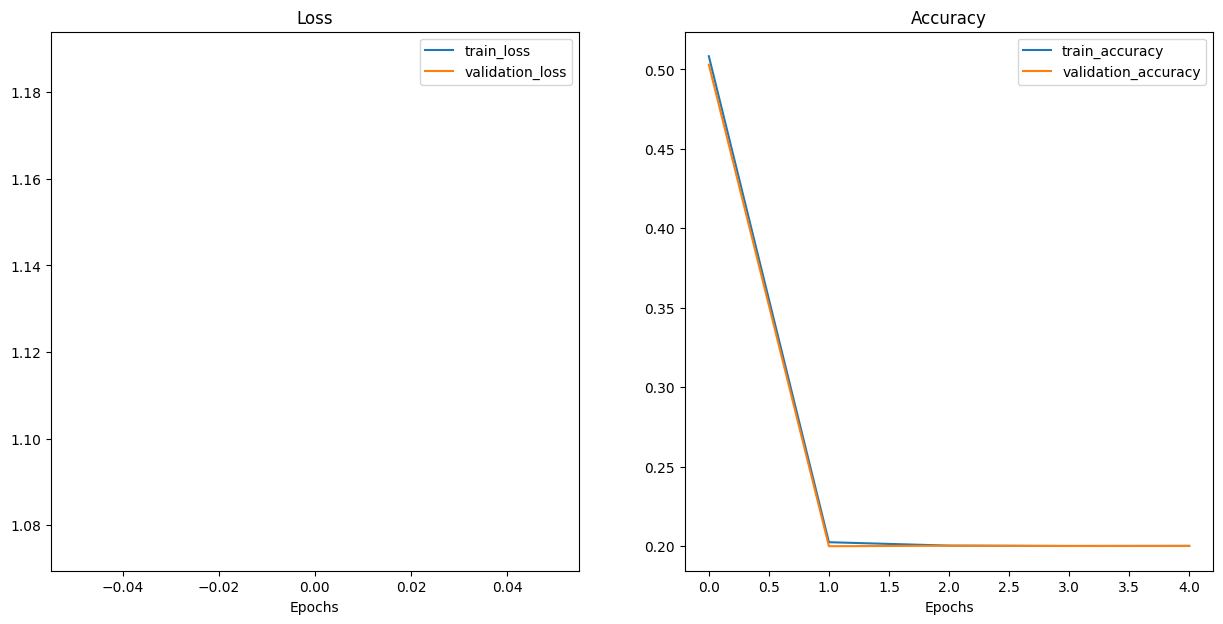

In [166]:
plot_loss_curves(results)

## 6. Test the model

Since we complete the training, we need to put data the model haven't seen before to test the performance.

### 6.1 Predict the test data

In [167]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [168]:
# 1. Make predictions with trained model
y_preds = []
y_true = []

set.to(device)
set.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
      # Send data and targets to target device
      X, y = X.to(device), y.to(device)
      # Do the forward pass
      y_logit = set(X)
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
      # Put predictions on CPU for evaluation, plot can only using CPU
      y_preds.append(y_pred.cpu())
      y_true.append(y.cpu())

# 将列表连接成张量
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

# 现在我们将这些张量转换为NumPy数组
y_pred_numpy = y_pred_tensor.numpy()
y_true_numpy = y_true_tensor.numpy()

Making predictions:   0%|          | 0/27 [00:00<?, ?it/s]

### 6.2 Confusion Matrix

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

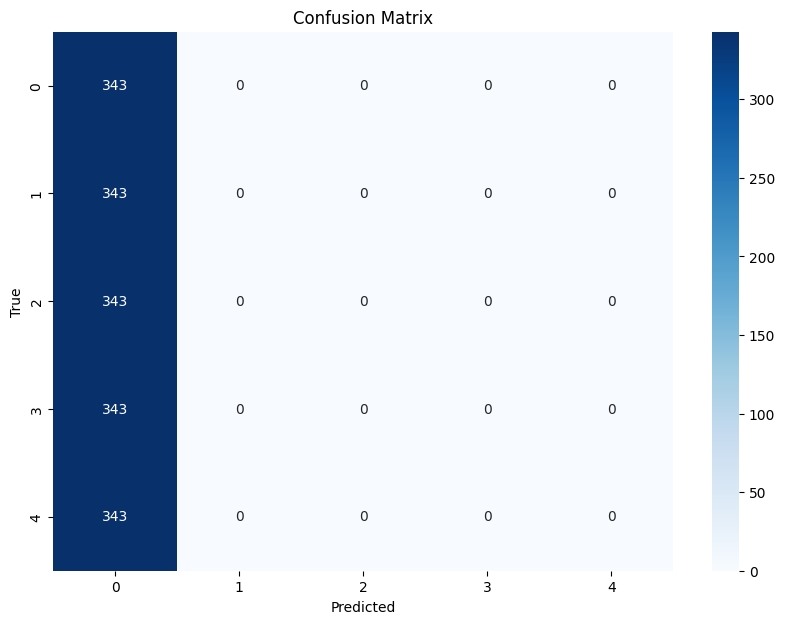

In [170]:
# 计算混淆矩阵
cm = confusion_matrix(y_true_numpy, y_pred_numpy)

# 使用seaborn来绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_name, yticklabels=class_name)

# 添加标题和标签
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7. Save model

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialzed object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

In [171]:
from pathlib import Path
import os

# 1. Create models directory 
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_PARA_NAME = f"SeT_HS_{HIDDEN_SIZE}_Layer_{NUM_LAYER}_Head_{NUM_HEAD}_Epoch_{NUM_EPOCH}_Para.pth"         # for parameters only
MODEL_NAME = f"SeT_HS_{HIDDEN_SIZE}_Layer_{NUM_LAYER}_Head_{NUM_HEAD}_Epoch_{NUM_EPOCH}_Model.pth"        # for entire model

### 7.1 Save parameters only using `state_dict()`

Using `state_dict()` means when you want to load the model parameter, you have to build the exactly same architecture of the model, otherwise the number of parameters doesn't match.

`state_dict()`: simply a python dictionary object that maps each layer to its parameter tensor.

In [172]:
# Save the model state dict, only saving the state_dict() only saves the models learned parameters
MODEL_PARA_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_PARA_NAME)
print(f"Saving model parameter to: {MODEL_PARA_SAVE_PATH}")
torch.save(set.state_dict(), MODEL_PARA_SAVE_PATH) 

Saving model parameter to: Models\SeT_HS_384_Layer_6_Head_6_Epoch_5_Para.pth


### 7.2 Save entire model using `torch.save()`

`torch.save(model, model_path)`

In [173]:
# Save the entire model
MODEL_SAVE_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
print(f"Saving entire model to: {MODEL_SAVE_PATH}")
torch.save(set, MODEL_SAVE_PATH) 

Saving entire model to: Models\SeT_HS_384_Layer_6_Head_6_Epoch_5_Model.pth


### 7.3 Load model using `torch.load()`

Model parameter: `model.load_state_dict(torch.load(model_path))`

In [174]:
# load model parameter, make sure the model architecture is the same
set = SeT()

set.load_state_dict(torch.load(MODEL_PARA_SAVE_PATH))

set.eval()          # start to evaluate the model

RuntimeError: Error(s) in loading state_dict for SeT:
	Missing key(s) in state_dict: "transformer_encoder.6.msa_block.layer_norm.weight", "transformer_encoder.6.msa_block.layer_norm.bias", "transformer_encoder.6.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.6.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.6.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.6.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.6.mlp_block.layer_norm.weight", "transformer_encoder.6.mlp_block.layer_norm.bias", "transformer_encoder.6.mlp_block.mlp.0.weight", "transformer_encoder.6.mlp_block.mlp.0.bias", "transformer_encoder.6.mlp_block.mlp.3.weight", "transformer_encoder.6.mlp_block.mlp.3.bias", "transformer_encoder.7.msa_block.layer_norm.weight", "transformer_encoder.7.msa_block.layer_norm.bias", "transformer_encoder.7.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.7.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.7.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.7.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.7.mlp_block.layer_norm.weight", "transformer_encoder.7.mlp_block.layer_norm.bias", "transformer_encoder.7.mlp_block.mlp.0.weight", "transformer_encoder.7.mlp_block.mlp.0.bias", "transformer_encoder.7.mlp_block.mlp.3.weight", "transformer_encoder.7.mlp_block.mlp.3.bias", "transformer_encoder.8.msa_block.layer_norm.weight", "transformer_encoder.8.msa_block.layer_norm.bias", "transformer_encoder.8.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.8.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.8.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.8.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.8.mlp_block.layer_norm.weight", "transformer_encoder.8.mlp_block.layer_norm.bias", "transformer_encoder.8.mlp_block.mlp.0.weight", "transformer_encoder.8.mlp_block.mlp.0.bias", "transformer_encoder.8.mlp_block.mlp.3.weight", "transformer_encoder.8.mlp_block.mlp.3.bias", "transformer_encoder.9.msa_block.layer_norm.weight", "transformer_encoder.9.msa_block.layer_norm.bias", "transformer_encoder.9.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.9.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.9.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.9.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.9.mlp_block.layer_norm.weight", "transformer_encoder.9.mlp_block.layer_norm.bias", "transformer_encoder.9.mlp_block.mlp.0.weight", "transformer_encoder.9.mlp_block.mlp.0.bias", "transformer_encoder.9.mlp_block.mlp.3.weight", "transformer_encoder.9.mlp_block.mlp.3.bias", "transformer_encoder.10.msa_block.layer_norm.weight", "transformer_encoder.10.msa_block.layer_norm.bias", "transformer_encoder.10.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.10.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.10.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.10.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.10.mlp_block.layer_norm.weight", "transformer_encoder.10.mlp_block.layer_norm.bias", "transformer_encoder.10.mlp_block.mlp.0.weight", "transformer_encoder.10.mlp_block.mlp.0.bias", "transformer_encoder.10.mlp_block.mlp.3.weight", "transformer_encoder.10.mlp_block.mlp.3.bias", "transformer_encoder.11.msa_block.layer_norm.weight", "transformer_encoder.11.msa_block.layer_norm.bias", "transformer_encoder.11.msa_block.multihead_attn.in_proj_weight", "transformer_encoder.11.msa_block.multihead_attn.in_proj_bias", "transformer_encoder.11.msa_block.multihead_attn.out_proj.weight", "transformer_encoder.11.msa_block.multihead_attn.out_proj.bias", "transformer_encoder.11.mlp_block.layer_norm.weight", "transformer_encoder.11.mlp_block.layer_norm.bias", "transformer_encoder.11.mlp_block.mlp.0.weight", "transformer_encoder.11.mlp_block.mlp.0.bias", "transformer_encoder.11.mlp_block.mlp.3.weight", "transformer_encoder.11.mlp_block.mlp.3.bias". 
	size mismatch for class_embedding: copying a param with shape torch.Size([1, 1, 384]) from checkpoint, the shape in current model is torch.Size([1, 1, 768]).
	size mismatch for position_embedding: copying a param with shape torch.Size([1, 13, 384]) from checkpoint, the shape in current model is torch.Size([1, 13, 768]).
	size mismatch for projection.up_project.weight: copying a param with shape torch.Size([384, 250]) from checkpoint, the shape in current model is torch.Size([768, 250]).
	size mismatch for projection.up_project.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.0.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.0.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.0.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.0.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.0.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.0.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.1.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.1.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.1.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.1.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.1.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.1.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.2.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.2.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.2.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.2.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.2.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.2.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.3.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.3.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.3.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.3.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.3.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.3.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.4.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.4.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.4.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.4.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.4.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.4.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.msa_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.msa_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.msa_block.multihead_attn.in_proj_weight: copying a param with shape torch.Size([1152, 384]) from checkpoint, the shape in current model is torch.Size([2304, 768]).
	size mismatch for transformer_encoder.5.msa_block.multihead_attn.in_proj_bias: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([2304]).
	size mismatch for transformer_encoder.5.msa_block.multihead_attn.out_proj.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for transformer_encoder.5.msa_block.multihead_attn.out_proj.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.mlp_block.layer_norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.mlp_block.layer_norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.5.mlp_block.mlp.0.weight: copying a param with shape torch.Size([3072, 384]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for transformer_encoder.5.mlp_block.mlp.3.weight: copying a param with shape torch.Size([384, 3072]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for transformer_encoder.5.mlp_block.mlp.3.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for classifier.0.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([5, 384]) from checkpoint, the shape in current model is torch.Size([5, 768]).

Entire model: `model = torch.load(model, model_path)`

In [ ]:
set = torch.load(MODEL_SAVE_PATH)

set.eval()          # start to evaluate the model

SeT(
  (projection): ProjectionModule(
    (up_project): Linear(in_features=250, out_features=768, bias=True)
  )
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Tra